FloatSlider(value=2.0, description='Food 1 X', max=10.0, min=-10.0)

FloatSlider(value=5.0, description='Food 2 X', max=10.0, min=-10.0)

FloatSlider(value=8.0, description='Food 3 X', max=10.0, min=-10.0)

FloatSlider(value=7.0, description='Food 4 X', max=10.0, min=-10.0)

FloatSlider(value=3.0, description='Food 1 Y', max=10.0, min=-10.0)

FloatSlider(value=6.0, description='Food 2 Y', max=10.0, min=-10.0)

FloatSlider(value=1.0, description='Food 3 Y', max=10.0, min=-10.0)

FloatSlider(value=8.0, description='Food 4 Y', max=10.0, min=-10.0)

FloatSlider(value=10.0, description='Food 1 Available', max=20.0)

FloatSlider(value=10.0, description='Food 2 Available', max=20.0)

FloatSlider(value=10.0, description='Food 3 Available', max=20.0)

FloatSlider(value=10.0, description='Food 4 Available', max=20.0)

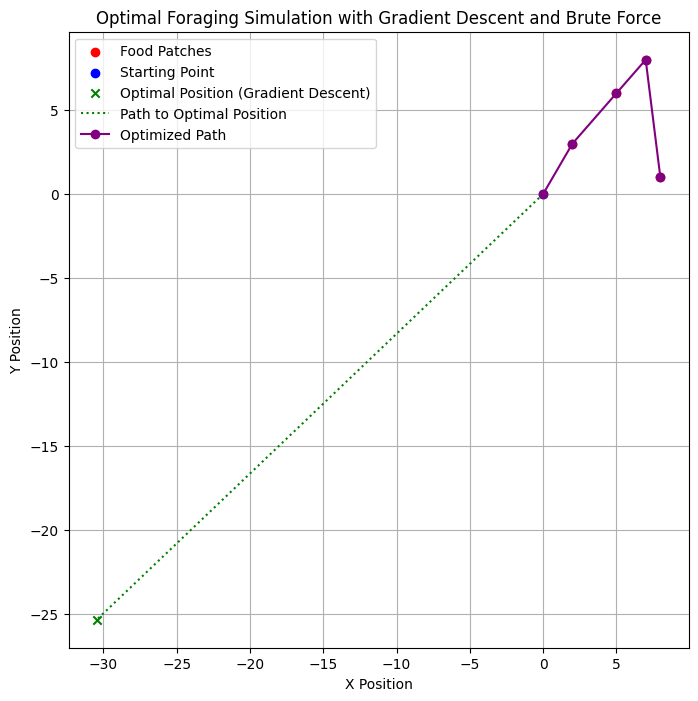

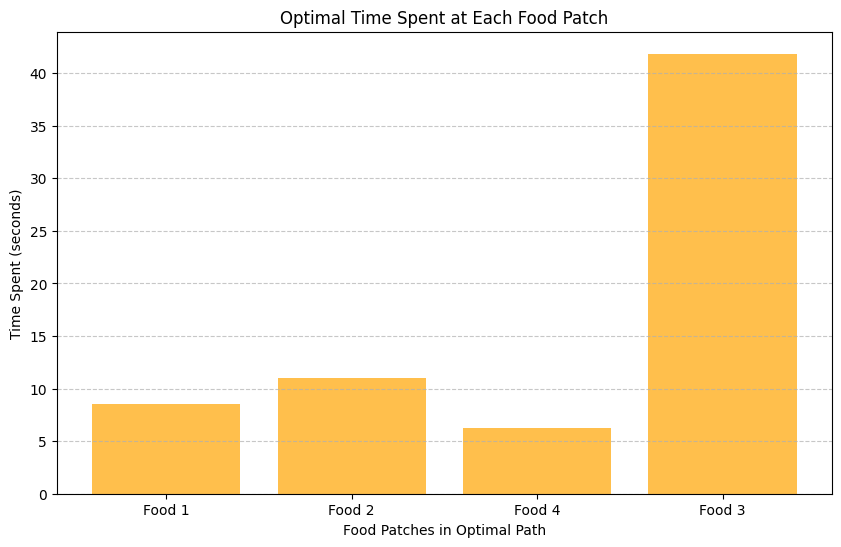

Optimal time at Food Patch 1: 8.54 seconds
Optimal time at Food Patch 2: 11.02 seconds
Optimal time at Food Patch 4: 6.20 seconds
Optimal time at Food Patch 3: 41.84 seconds


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets

energy_per_food_item_default = 10  # Energy obtained from a food item
travel_cost_per_distance = 1  # Energy cost per unit of distance

food_patches = np.array([[2, 3], [5, 6], [8, 1], [7, 8]])  # Initial positions of food patches
food_available = np.array([energy_per_food_item_default] * len(food_patches))  # Initial food amounts

def energy_intake(food_patch, current_position, food_amount):
    distance = np.linalg.norm(food_patch - current_position)
    return food_amount / (1 + distance)

def energy_expenditure(start, end):
    return np.linalg.norm(end - start) * travel_cost_per_distance

def gradient_of_cost_function(current_position, food_patches, food_available):
    grad_x = np.zeros(len(food_patches))
    grad_y = np.zeros(len(food_patches))

    for i, patch in enumerate(food_patches):
        distance = np.linalg.norm(patch - current_position)
        grad_x[i] = (patch[0] - current_position[0]) / (distance + 1e-6)
        grad_y[i] = (patch[1] - current_position[1]) / (distance + 1e-6)

    return grad_x, grad_y

# Finding the optimal position with gradient descent
def gradient_descent(food_patches, food_available, learning_rate=0.1, iterations=100):
    current_position = np.array([0.0, 0.0])

    for _ in range(iterations):
        grad_x, grad_y = gradient_of_cost_function(current_position, food_patches, food_available)
        current_position[0] -= learning_rate * np.sum(grad_x)
        current_position[1] -= learning_rate * np.sum(grad_y)

    return current_position

# Optimal path selection
def total_energy_and_cost(path, food_patches, food_available):
    total_energy = 0
    total_cost = 0
    current_position = np.array([0, 0])

    for idx in path:
        next_patch = food_patches[idx]
        total_energy += energy_intake(next_patch, current_position, food_available[idx])
        total_cost += energy_expenditure(current_position, next_patch)
        current_position = next_patch

    return total_cost - total_energy

def optimize_foraging(food_patches, food_available):
    num_patches = len(food_patches)
    all_possible_paths = np.array(np.meshgrid(*[range(num_patches)] * num_patches)).T.reshape(-1, num_patches)
    valid_paths = [path for path in all_possible_paths if len(set(path)) == num_patches]
    best_path = None
    min_cost = float('inf')
    for path in valid_paths:
        cost = total_energy_and_cost(path, food_patches, food_available)
        if cost < min_cost:
            min_cost = cost
            best_path = path
    return best_path

def optimal_time_at_patch(food_patch, current_position, food_amount, energy_per_food_item, travel_cost):
    distance = np.linalg.norm(food_patch - current_position)
    rate_of_gain = energy_per_food_item / (1 + distance)
    rate_of_loss = travel_cost
    optimal_time = food_amount / (rate_of_gain - rate_of_loss) if rate_of_gain > rate_of_loss else 0
    return max(optimal_time, 0)

def update_simulation(*args):
    global food_patches, food_available


    food_patches = np.array([[slider_x[i].value, slider_y[i].value] for i in range(len(food_patches))])
    food_available = np.array([slider_food[i].value for i in range(len(food_patches))])

    optimal_position = gradient_descent(food_patches, food_available)
    optimal_path = optimize_foraging(food_patches, food_available)

    # MVT
    times = [
        optimal_time_at_patch(
            food_patches[idx],
            np.array([0, 0]) if i == 0 else food_patches[optimal_path[i - 1]],
            food_available[idx],
            energy_per_food_item_default,
            travel_cost_per_distance
        )
        for i, idx in enumerate(optimal_path)
    ]

    plt.figure(figsize=(8, 8))
    plt.scatter(food_patches[:, 0], food_patches[:, 1], color='red', label='Food Patches')
    plt.scatter(0, 0, color='blue', label='Starting Point')
    plt.scatter(optimal_position[0], optimal_position[1], color='green', label='Optimal Position (Gradient Descent)', marker='x')

    plt.plot([0, optimal_position[0]], [0, optimal_position[1]], color='green', linestyle='dotted', label='Path to Optimal Position')

    current_position = np.array([0, 0])
    path_x = [current_position[0]]
    path_y = [current_position[1]]
    for idx in optimal_path:
        next_patch = food_patches[idx]
        path_x.append(next_patch[0])
        path_y.append(next_patch[1])
    plt.plot(path_x, path_y, color='purple', label='Optimized Path', marker='o')

    plt.title('Optimal Foraging Simulation with Gradient Descent and Brute Force')
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.legend()
    plt.grid(True)
    plt.show()


    patch_labels = [f"Food {idx + 1}" for idx in optimal_path]
    plt.figure(figsize=(10, 6))
    plt.bar(patch_labels, times, color='orange', alpha=0.7)
    plt.title('Optimal Time Spent at Each Food Patch')
    plt.xlabel('Food Patches in Optimal Path')
    plt.ylabel('Time Spent (seconds)')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()



    for i, t in enumerate(times):
        print(f"Optimal time at Food Patch {optimal_path[i]+1}: {t:.2f} seconds")



slider_x = [widgets.FloatSlider(value=food_patches[i, 0], min=-10, max=10, step=0.1, description=f"Food {i+1} X") for i in range(len(food_patches))]
slider_y = [widgets.FloatSlider(value=food_patches[i, 1], min=-10, max=10, step=0.1, description=f"Food {i+1} Y") for i in range(len(food_patches))]
slider_food = [widgets.FloatSlider(value=food_available[i], min=0, max=20, step=0.1, description=f"Food {i+1} Available") for i in range(len(food_patches))]


for slider in slider_x + slider_y + slider_food:
    slider.observe(update_simulation, names='value')


display(*slider_x, *slider_y, *slider_food)


update_simulation()